In [28]:
import torch 
from matplotlib import pyplot as plt 
from tkgdti.train.utils import device_and_data_loading
import argparse 
from tkgdti.data.TriplesDatasetGNN import TriplesDatasetGNN
from tkgdti.data.process_graph import process_graph
import torch_geometric as pyg
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve 
import seaborn as sbn 

In [39]:
df = pd.read_csv('../output/gnn/transformer/predictions.csv')

In [40]:
df.head()

,drug,protein,prob,drug_name,prot_name,train,valid,test,negatives
0,0,0,0.000083,DB00050,Q9UI32,False,False,False,True
1,0,1,0.000085,DB00050,P00488,False,False,False,True
2,0,2,0.000235,DB00050,P35228,False,False,False,True
3,0,3,0.000083,DB00050,P06737,False,False,False,True
4,0,4,0.000083,DB00050,P11766,False,False,False,True


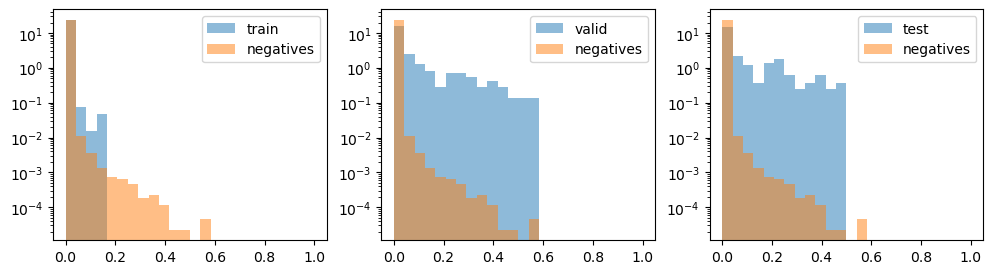

In [41]:
_bins = np.linspace(0, 1, 25)
_alpha = 0.5 
_density = True

f,axes = plt.subplots(1, 3, figsize=(12,3))


axes[0].hist(df['prob'][df['train']], bins=_bins, alpha=_alpha, label='train', density=_density)
axes[0].hist(df['prob'][df['negatives']], bins=_bins, alpha=_alpha, label='negatives', density=_density)
axes[0].legend() 
axes[0].set_yscale('log')

axes[1].hist(df['prob'][df['valid']], bins=_bins, alpha=_alpha, label='valid', density=_density)
axes[1].hist(df['prob'][df['negatives']], bins=_bins, alpha=_alpha, label='negatives', density=_density)
axes[1].legend() 
axes[1].set_yscale('log')

axes[2].hist(df['prob'][df['test']], bins=_bins, alpha=_alpha, label='test', density=_density)
axes[2].hist(df['prob'][df['negatives']], bins=_bins, alpha=_alpha, label='negatives', density=_density)
axes[2].legend() 
axes[2].set_yscale('log')

plt.show()

In [42]:
y = df[lambda x: x.negatives | x.test].test 
yhat = df[lambda x: x.negatives | x.test].prob

auroc = roc_auc_score(y, yhat)
auprc = average_precision_score(y, yhat)

print(f'AUC: {auroc}')
print(f'AP: {auprc}')

AUC: 0.924896247641563
AP: 0.1262082469267114


In [43]:
# gassign drug-specific protein ranks based on prob 
df = df.groupby('drug_name').apply(lambda x: x.assign(rank=x['prob'].rank(ascending=False))).reset_index(drop=True)

/tmp/ipykernel_16205/388573794.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('drug_name').apply(lambda x: x.assign(rank=x['prob'].rank(ascending=False))).reset_index(drop=True)


In [44]:
mrr = np.mean(1/df[lambda x: x.test]['rank']) 
top1 = np.mean(df[lambda x: x.test]['rank'] == 1)
top3 = np.mean(df[lambda x: x.test]['rank'] <= 3)
top10 = np.mean(df[lambda x: x.test]['rank'] <= 10)
top100 = np.mean(df[lambda x: x.test]['rank'] <= 100)

print(f'MRR: {mrr}')
print(f'Top1: {top1}')
print(f'Top3: {top3}')
print(f'Top10: {top10}')
print(f'Top100: {top100}')

MRR: 0.39779248997096295
Top1: 0.29015544041450775
Top3: 0.44559585492227977
Top10: 0.6113989637305699
Top100: 0.7979274611398963


In [45]:
# slightly different way to calculate ranks
# removes the potential contribution of train/valid partitions and only compares test vs negatives

ranks = [] 
aurocs = [] 
auprcs = []
for i,drug in enumerate(df.drug_name.unique()): 
    print(f'progress: {i}/{len(df.drug_name.unique())}', end='\r')
    tmp = df[lambda x: x.drug_name == drug]
    tmp = tmp[lambda x: x.test | x.negatives]
    if tmp.test.astype(float).sum() < 1: continue
    aurocs.append( roc_auc_score(tmp.test.astype(float), tmp.prob) )
    auprcs.append( average_precision_score(tmp.test.astype(float), tmp.prob) )

    tmp_pos = tmp[lambda x: x.test]

    for i, row in tmp_pos.iterrows(): 
        rank = (tmp.prob >= row.prob).sum()
        ranks.append(rank)

ranks = np.array(ranks)
mrr = np.mean(1/ranks)
top1 = np.mean(ranks == 1)
top3 = np.mean(ranks <= 3)
top10 = np.mean(ranks <= 10)
top100 = np.mean(ranks <= 100)

print(f'MRR: {mrr}')
print(f'Top1: {top1}')
print(f'Top3: {top3}')
print(f'Top10: {top10}')
print(f'Top100: {top100}')

print(f'avg AUC (within drug): {np.mean(aurocs)}')
print(f'avg AP (within drug): {np.mean(auprcs)}')


MRR: 0.4161109951387599
Top1: 0.31088082901554404
Top3: 0.47150259067357514
Top10: 0.6113989637305699
Top100: 0.7979274611398963
avg AUC (within drug): 0.9265735888834109
avg AP (within drug): 0.45029229990132363


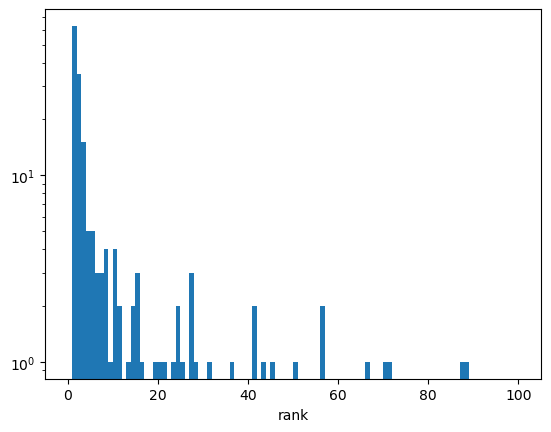

In [18]:
plt.figure()
plt.hist(ranks, bins=np.linspace(0, 100, 101))
plt.xlabel('rank')
plt.yscale('log')
plt.show()

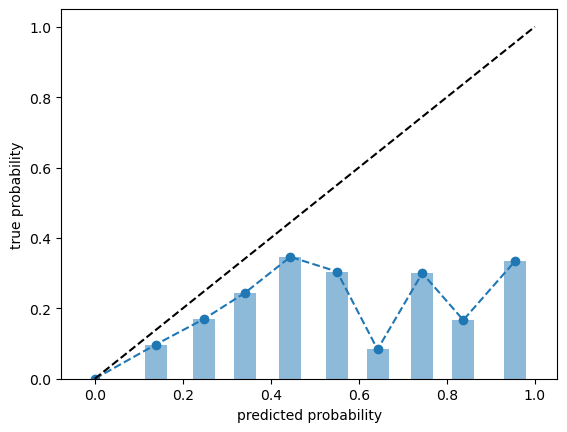

In [20]:
yhat = df[lambda x: x.negatives | x.test].prob.values
y = df[lambda x: x.negatives | x.test].test.values  

n_bins = 10
prob_true, prop_pred = calibration_curve(y, yhat, n_bins=n_bins, strategy='uniform')

plt.figure()
plt.plot(prop_pred, prob_true, 'o--')
plt.bar(x=prop_pred, height=prob_true, width=(1/(2*n_bins)), alpha=0.5)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('predicted probability')
plt.ylabel('true probability')
plt.show()

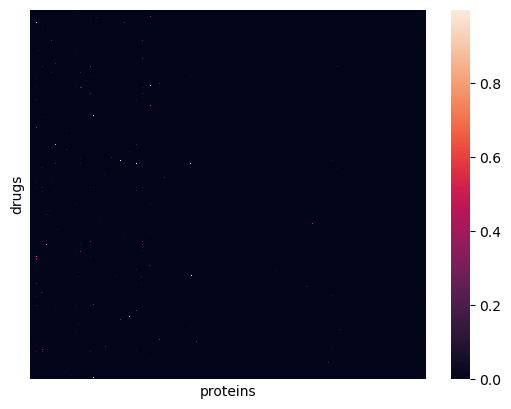

In [26]:
# dense predictions 
Ascore = np.zeros((data['num_nodes_dict']['drug'], data['num_nodes_dict']['protein']))
for i,j,score in zip(df.drug, df.protein, df.prob): 
    Ascore[i,j] = score 

plt.figure()
sbn.heatmap(Ascore, xticklabels=False, yticklabels=False)
plt.xlabel('proteins')
plt.ylabel('drugs')
plt.show()

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

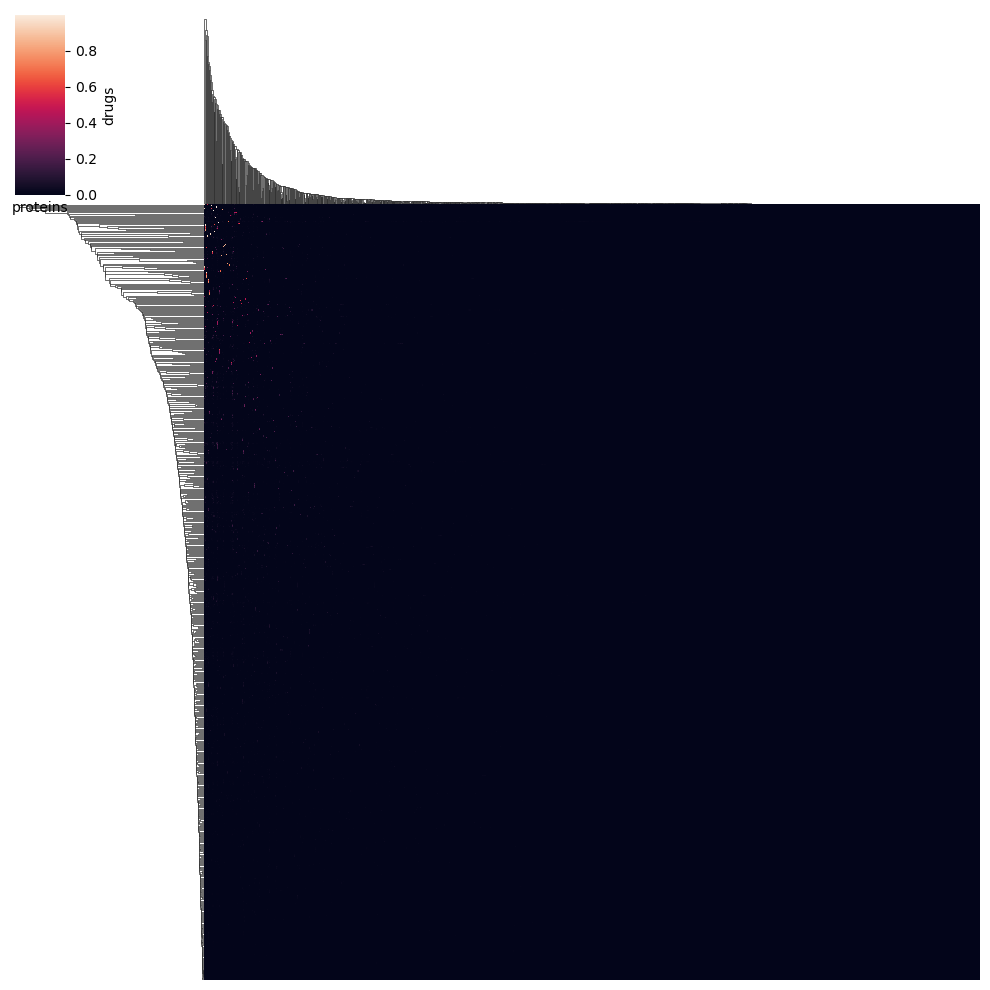

In [27]:
plt.figure()
sbn.clustermap(Ascore, xticklabels=False, yticklabels=False)
plt.xlabel('proteins')
plt.ylabel('drugs')
plt.show()